Exercise 8: Classifying Supersymmetry
=========================

The [Large Hadron Collider] (LHC) is a machine for smashing high-speed atomic nuclei into
each other.  Each collision is observed by one of the two large detectors (ATLAS and CMS), which are
like huge digital cameras taking snapshots of the particles generated in the
collision. The LHC generates 40,000,000 collision events per second per experiment, and a CMS "photograph" of
one such event is around one MB in size.  Storing every event, let alone analyzing it,
is completely infeasible.

Fortunately, in a hadron collider, as in presentations of vacation pictures, the vast majority
of photographs are "boring", which means no new physics is expected to be observed there.
We will classify those events as **background** and assign to it the label `0`.  The collision events
interesting for our application are classified as **signal** and have the label `1`.  Note that an
event being signal does not mean it contains new physics; it just means it is a collision
where new physics *may* be seen.

One theory for which the LHC is on the lookout is [supersymmetry], or SUSY for short.  We won't 
have time to go into the details: suffice it to say, it is a much-sought-after theory by high-energy 
physicists because if true, it would solve a series of problems with the standard model and greatly
simplify the maths.  However, until now nature has refused to play along and no experimental evidence
of SUSY has been found.

In this exercise you will have to train a model which classifies events as signal or background for
the purposes of SUSY, given 18 hand-picked `variables` observed in each event (the explanations
are given in `variable_names`).  The [dataset] has 5,000,000 events, generated from simulations, together
with their true classification (`labels`).

[Large Hadron Collider]: https://en.wikipedia.org/wiki/Large_Hadron_Collider
[supersymmetry]: https://en.wikipedia.org/wiki/Supersymmetry
[dataset]: https://www.nature.com/articles/ncomms5308

In [2]:
import os
import numpy as np
import matplotlib.pyplot as pl

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-u2kthxyn because the default path (/home/e00473828/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
# Load the dataset from a binary file
with np.load(os.path.expanduser("~/shared/susy.npz")) as _datafile:
    labels = _datafile["labels"].astype(int)
    variables = _datafile["variables"].astype(float)
    variable_names = list(_datafile["variable_names"].astype(str))

In [4]:
variable_names

['lepton 1 pT',
 'lepton 1 eta',
 'lepton 1 phi',
 'lepton 2 pT',
 'lepton 2 eta',
 'lepton 2 phi',
 'missing energy magnitude',
 'missing energy phi',
 'MET_rel',
 'axial MET',
 'M_R',
 'M_TR_2',
 'R',
 'MT2',
 'S_R',
 'M_Delta_R',
 'dPhi_r_b',
 'cos(theta_r1)']

In [5]:
variables.shape

(5000000, 18)

In [6]:
labels.shape

(5000000,)

In [7]:
labels[:10]

array([0, 1, 1, 1, 1, 0, 0, 0, 1, 0])

Step 1: Partition the data into a training and a test set
---------------------------------------------------------------------------

Fill variables `X_train`, `y_train` with design matrix and labels
of the training set, and the same for `X_test` and `y_test` for the
test set.

You should put 90% of observations into the training set and 10% into the
test set.

The data has been randomized, so you do not need to do this here
(but can if you like.)

In [8]:
cutoff = int(0.9 * len(labels))

X_train = variables[:cutoff, :]
y_train = labels[:cutoff]

X_test = variables[cutoff:, :]
y_test = labels[cutoff:]

In [9]:
assert (X_train, y_train, X_test, y_test) is not None
assert X_train.shape[:1] == y_train.shape
assert X_test.shape[:1] == y_test.shape
np.testing.assert_allclose(y_train.size / y_test.size, 9)

Step 2: Train a logistic model
--------------------------------------

Our days of writing all of those fitting things ourselves are now behind us.
We are going to leverage the power of the scikit-learn (`sklearn`) package.
This also means I will step back a little bit and you will have to figure
out more things on your own.

Let us use a `sklearn.linear_model.SGDClassifier` (see the [documentation]),
which is a binary classifier using stochastic gradient descent.

Training with sklearn is two-step procedure:

 1. first, you create a `model`, which encodes both which predictor/classifier
    we are using and how we are going to train it. In our case this is a 
    `SGDClassifier`.   As parameters you should make sure to use the loss function
    for logistic regression and use early stopping.
    
 2. second, we are going to perform the regression on the data set using
    the `fit` method of the model.  Here you should pass the training data.

[documentation]: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier

In [10]:
import sklearn.linear_model

In [11]:
model = sklearn.linear_model.SGDClassifier(loss='log_loss', early_stopping=True)
model.fit(X_train, y_train);

In [12]:
assert (model,) is not None
assert model.__class__.__name__ == "SGDClassifier"
assert model.score(X_train, y_train) < 1

Step 3: Predict values on the test set and check errors
---------------------------------------------

Now that the model is trained, we can use it to predict values for
the test set, which you should store in `yhat_test`.

Afterwards, compute the in- and out-of-sample error and store it
in `E_in` and `E_out`, respectively.

**Hint**: For both tasks you may have to rummage through the methods of `model` a
little bit or read the documentation.  The error is called "score"
in sklearn terminology.

In [13]:
yhat_test = model.predict(X_test)

E_in = model.score(X_train, y_train)
E_out = model.score(X_test, y_test)

In [14]:
print ("in-sample (training) error:%10.5f" % E_in)
print ("out-of-sample (test) error:%10.5f" % E_out)

in-sample (training) error:   0.78865
out-of-sample (test) error:   0.78921


In [15]:
assert (yhat_test, E_in, E_out) is not None
_am_right = (yhat_test == y_test).sum()
assert _am_right > 350_000, "Poor prediction accuracy" 
assert _am_right < 499_000, "Too good prediction accuracy"
assert 0 < E_in < 1
assert 0 < E_out < 1

Step 4: Evaluate prediction quality
------------------------------

Compute and print/plot the **confusion matrix** (on the test set).

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, recall_score

Text(0.5, 1.0, 'Confusion Matrix')

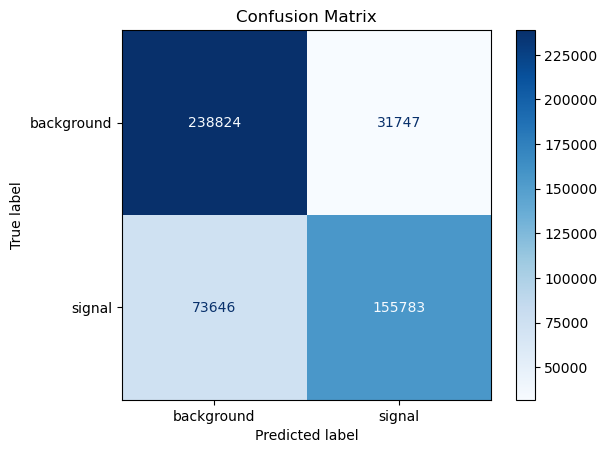

In [27]:
cm = confusion_matrix(y_test, yhat_test)
ConfusionMatrixDisplay(cm, display_labels=['background', 'signal']).plot(cmap='Blues');
pl.title("Confusion Matrix")

You should also compute the accuracy, sensitivity, and specificity
and store it in `accuracy`, `sensitivity`, and `specificity`,
respectively and then print those values as well.

In [18]:
tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, yhat_test)
sensitivity = recall_score(y_test, yhat_test)
specificity = tn / (tn + fp)
BSR = (tn + fp) / (fn+tp)

In [19]:
assert 0.5 < accuracy < 0.95
assert 0.5 < sensitivity < 0.95
assert 0.5 < specificity < 0.95
assert sensitivity < specificity


In [20]:
print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print(f"Background-to-signal ratio:\t {BSR:.3f} : 1")

Accuracy: 0.789214
Sensitivity: 0.6790030902806533
Specificity: 0.8826666568109665
Background-to-signal ratio:	 1.179 : 1


Draw conclusions based on your metrics:

 1. Is the dataset significantly imbalanced?
 
 2. Observe that the sensitivity is smaller than the
    specificity.  What does this mean? 
  
 3. Is this model suitable for finding regions of interest
    for SUSY search in the data? Why or why not?

### 1) Dataset Balance

With a background-to-signal ratio of **1.179: 1** I would say the dataset is sufficiently balanced that so that we can rule that out as a cause for any potential issues with the models prediction power

### 2) Sensitivity < Specificity

**Sensitivity:** (a.k.a True positive rate / hit rate/ recall) is a measure for the models aility to identify **hits** (hence low misses).
**Specificity:** Sort of the opposite of sensitivity and is a measure for the models ability to make **correct rejections** (hence low false alarms).

In our case **sensitivity $<$ specificity** and hence this means that our models is better at correctly identifying '*boring*' **background data** than it is at correctly identifying '*interesting*' **signal data**

Put differently our model will have a higher tendency to make **misses** (misclassifying actual signals as background)  rather than **false alarms** (misclassifying backgrounds as signals).

### 3) Suitable for SUSY?
Whether or not the model is suitable for SUSY depends on the priorities of the researchers and which trade-offs they are willing to make.

If it is important that none of the true signals are missed and they all should be analysed then the Sensitivity of $\approx 0.67$ may be too low. One could argue that missing **hits** and mistakenly classifying them as background, would mean we need to run the LHC for longer durations of time to collect the same amount of interesting data as a better model could do. This is obviously very costly and thus one may say the model is not good enough.

On the other if the issue is not the amount of data gathered but rather the time it takes to process the data (if for example for each measurement some poor PhD student has to use a month of their valuable to do the analysis), then one could say that it is more important that we accurately identify the background signal and make sure we do not waste time processing **false alarms** (background misclassified as signal). In this case having a Specificity of $\approx 0.89$ may mean our model is pretty good already in that regard.

Step 5: Debugging the model
------------------------------

In an effort to improve the model, one question one can naturally ask is **which**
features are modelled accurately and which features are not.

For this, put all observations of the test design matrix `X_test` which were
predicted incorrectly into `X_fail`, and those which were predicted correctly
into `X_success`.

In [21]:
success_classifier = yhat_test == y_test
X_success = X_test[success_classifier, :]
X_fail = X_test[np.invert(success_classifier), :]

In [22]:
assert X_fail.shape[1] == X_test.shape[1]
assert X_fail.shape[0] == (yhat_test != y_test).sum()
assert X_success.shape[1] == X_test.shape[1]
assert X_success.shape[0] == (yhat_test == y_test).sum()


Now let us do a (quite crude!) analysis of where this may go wrong:
If values for feature, say $x_k$, are on average very different in the
training set than in the test set, then we can probably assume that the
dependency on this feature cannot be properly captured by our model.

To study this:

 1. let us first take the **mean** over hits and misses for each feature (mean over 
    the columns of `X_fail` and `X_success`) - let us call this $\bar x^\mathrm{hit}_k$
    and $\bar x^\mathrm{miss}_k$, respectively.
    
 2. to make sure that our "distances" are meaningful, let us also compute
    the **standard deviation** over all observations for each feature (standard
    deviation over the columns of `variables`) - we call this $\sigma_k$.

(Hint: you can use the `mean` and `std` function together with the axis
argument.)

Now plot the $\bar x^\mathrm{hit}_k / \sigma_k$ and $\bar x^\mathrm{miss}_k / \sigma_k$
over $k$. To spot the difference, I suggest plotting these as two lines in 
the same plot.

Text(0.5, 1.0, 'Plot to help identify parameters responsible for misses')

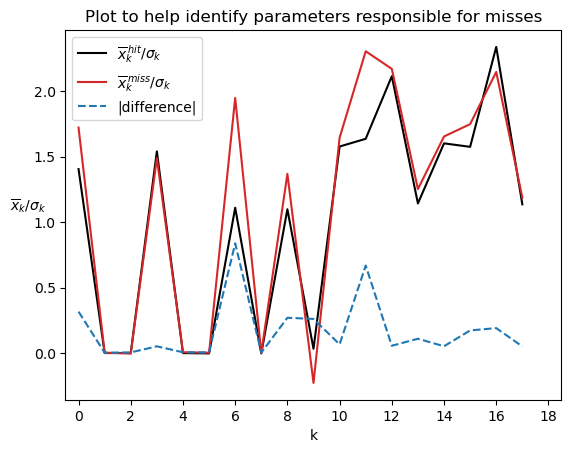

In [23]:
from matplotlib.ticker import MaxNLocator

xhit = np.mean(X_success, axis=0) / np.std(X_success, axis=0)
xmiss = np.mean(X_fail, axis=0) / np.std(X_fail, axis=0)

pl.plot(xhit, label=r"$\overline{x}_{k}^{\,hit} / \sigma_{k}$", c='k')
pl.plot(xmiss, label=r"$\overline{x}_{k}^{\,miss} / \sigma_{k}$", c='C3')
pl.plot(np.abs(xhit-xmiss), label=r"|difference|", linestyle='--')

pl.ylabel(r"$\overline{x}_{k} / \sigma_{k}$", rotation=0)
pl.xlabel('k')
pl.xlim(-0.5, 18.5)
pl.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
pl.legend()
pl.title("Plot to help identify parameters responsible for misses")

 1. According to the above plot, which features are most likely involved in poor
    predictions?

 2. How could we modify the design matrix such that we allow the logistic model
    to treat these features (potentially) better?

### 1) Feautures responsible for misses
Sticking with our "quite crude" analysis method, we can assume that the feautures responsible for the **misses** are those whose std-normalised means differ the most from those of the **hits**. Looking at the blue dotted line in the plot above we can see that the two clear outliers are feauture **$k=6$** (*missing energy magnitude*) and **$k=11$** (*M_TR_2*). If we are being very picky we could additionally also include feautures $k=0,8,9$.

### 2) Improvements through Design Matrix Modifications
This is a hard question as I think there are many ways in which one may attempt to mitigate this issue. The crudest approach would be to simply completely remove those feautures from the design matrix, but I attempted this and it made both the sensitivity and the specificity worse, hence indicating that those feautures still add value overall and should not be removed completely.

A bit better than the crude apporach would be to try to do feauture selection by using better statistical techniques to determine which feautures most impact the hit and miss rates, and remove feautures based on that.

Using different regularisation (such as lasso) would also have feauture selection built in already, but I tried this and it did not make a real difference, hence I think that getting rid of features is not the way to go here. (Also this would not directly make a change to the design matrix as was asked)

So maybe the solution would lie in doing some feauture engineering by transforming the feautures we have chosen in some way, before training the model. One could think about scaling / normalizing those feautures based on some criteria (did not make a real difference when I tried it), or one could attempt to do some polynomial transformations on those feautures to aid the model in capturing potential non-linear effects (again I could not make apprecaible improvements using simple guesses at this, but maybe with further analysis this could work).  

One could also try to combine feautures in different ways to possibly capture certain interactions/ correlations between them better. I did not really attemp this though.

Not sure if there is anything quick and simple one could really do to make big improvements here. But lots of things to try at least.